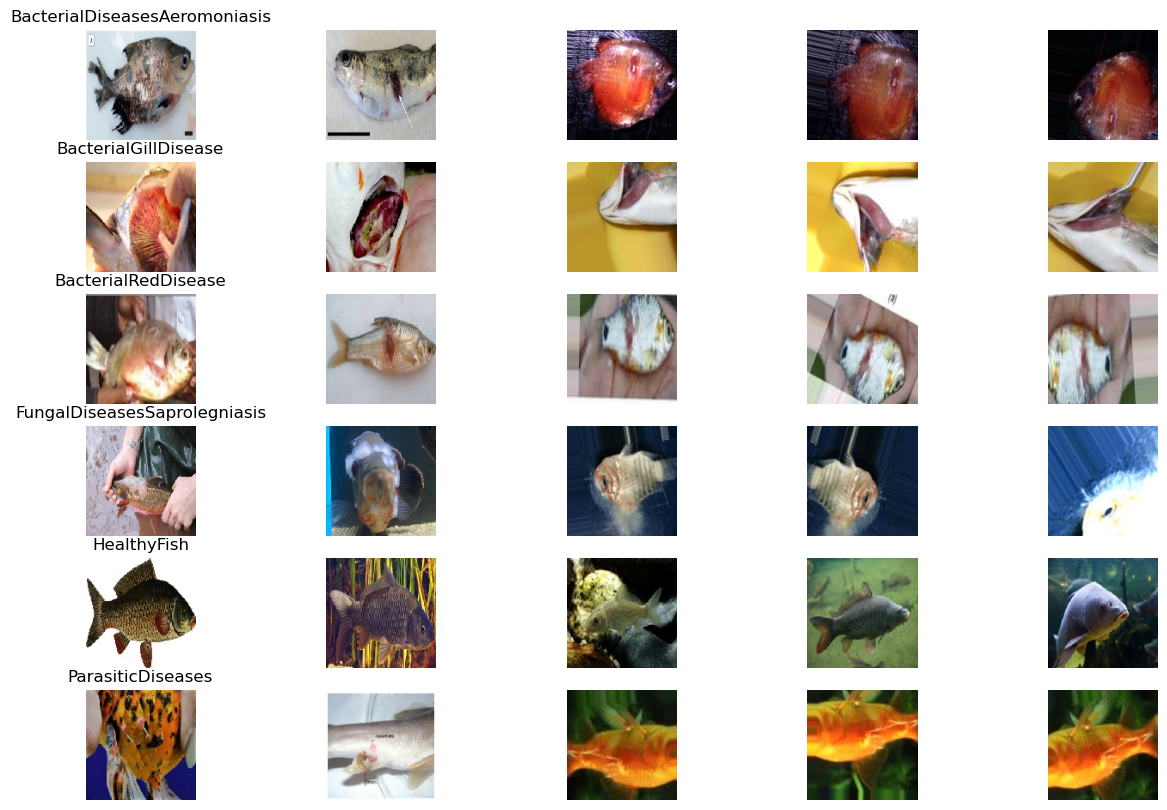

In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt

def read_image(img_path):
    with open(img_path, 'rb') as f:
        img = plt.imread(f)
    return img

def resize_image(img, new_width, new_height):
    original_height, original_width, channels = img.shape
    resized_img = np.zeros((new_height, new_width, channels))
    
    for i in range(new_height):
        for j in range(new_width):
            x = int(j * original_width / new_width)
            y = int(i * original_height / new_height)
            resized_img[i, j] = img[y, x]
    
    return resized_img

def preprocess_image(img_path, img_size):
    img = read_image(img_path)
    if img.shape[-1] == 4:  # If the image has 4 channels (RGBA), take only 3 channels (RGB)
        img = img[:, :, :3]
    img_resized = resize_image(img, img_size, img_size)
    img_normalized = img_resized / 255.0
    return img_normalized

def load_and_process_images(data_dir, img_size, folders):
    images = []
    labels = []
    
    for folder in folders:
        class_path = os.path.join(data_dir, folder)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if img_name.startswith('.'):
                    continue  # Skip hidden files or folders
                if img_name.lower().endswith(('.jpg','.png' '.jpeg')):  
                    img_path = os.path.join(class_path, img_name)
                    try:
                        img_processed = preprocess_image(img_path, img_size)
                        if img_processed.shape == (img_size, img_size, 3):  
                            images.append(img_processed)
                            labels.append(folder)
                        else:
                            print(f"Inconsistent image shape at {img_path}: {img_processed.shape}")
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    return images, labels

# Set data directory and image size
data_dir = 'penyakit_ikan_air_tawar/Train'
img_size = 128
folders = ["BacterialDiseasesAeromoniasis", "BacterialGillDisease", "BacterialRedDisease", "FungalDiseasesSaprolegniasis", "HealthyFish", "ParasiticDiseases"]


# Load and process data
images, labels = load_and_process_images(data_dir, img_size, folders)

# Ensure all images have the same size before converting to NumPy array
try:
    images_array = np.array(images)
    labels_array = np.array(labels)
except Exception as e:
    print(f"Error converting to numpy array: {e}")

# Display some images from each folder
def plot_images(images, labels, folders, img_size):
    fig, axs = plt.subplots(len(folders), 5, figsize=(15, 10))
    for i, folder in enumerate(folders):
        folder_images = [img for img, label in zip(images, labels) if label == folder][:5]
        for j, img in enumerate(folder_images):
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(folder)
    plt.show()

# Display images from the dataset
plot_images(images_array, labels_array, folders, img_size)

In [30]:
from PIL import Image
import csv
# Fungsi untuk membuat GLCM secara manual
def calculate_glcm(image, distance=1, angle=0):
    max_gray = image.max() + 1  # Nilai maksimal level grayscale
    glcm = np.zeros((max_gray, max_gray), dtype=int)  # Inisialisasi matriks GLCM

    # Mendefinisikan pergeseran piksel berdasarkan sudut
    if angle == 0:  # Horizontal
        dx, dy = distance, 0
    elif angle == 90:  # Vertikal
        dx, dy = 0, distance
    elif angle == 45:  # Diagonal 45 derajat
        dx, dy = distance, -distance
    elif angle == 135:  # Diagonal 135 derajat
        dx, dy = -distance, -distance
    else:
        raise ValueError("tidak support cahaya untuk kalkulasi GLCM.")

    rows, cols = image.shape
    for i in range(rows):
        for j in range(cols):
            x = j + dx
            y = i + dy
            if x >= 0 and x < cols and y >= 0 and y < rows:
                current_pixel = image[i, j]
                neighbor_pixel = image[y, x]
                glcm[current_pixel, neighbor_pixel] += 1

    return glcm

# Fungsi untuk normalisasi GLCM
def normalize_glcm(glcm):
    return glcm / glcm.sum()

# Fungsi untuk ekstraksi fitur tekstur dari GLCM
def extract_glcm_features(glcm):
    contrast = 0
    dissimilarity = 0
    homogeneity = 0
    energy = 0
    correlation = 0

    mean_i = 0
    mean_j = 0
    var_i = 0
    var_j = 0

    rows, cols = glcm.shape
    total = glcm.sum()

    # Hitung mean dan varians
    for i in range(rows):
        for j in range(cols):
            mean_i += i * glcm[i, j]
            mean_j += j * glcm[i, j]

    for i in range(rows):
        for j in range(cols):
            var_i += ((i - mean_i) ** 2) * glcm[i, j]
            var_j += ((j - mean_j) ** 2) * glcm[i, j]

    # Hitung fitur tekstur
    for i in range(rows):
        for j in range(cols):
            p_ij = glcm[i, j]
            contrast += (i - j) ** 2 * p_ij
            dissimilarity += abs(i - j) * p_ij
            homogeneity += p_ij / (1.0 + (i - j) ** 2)
            energy += p_ij ** 2
            if var_i > 0 and var_j > 0:
                correlation += ((i - mean_i) * (j - mean_j) * p_ij) / (np.sqrt(var_i * var_j))

    return contrast, dissimilarity, homogeneity, energy, correlation

# Fungsi untuk menyimpan hasil ekstraksi ke CSV
def save_to_csv_glcm(results, folder,output_file):
    file_exists = os.path.isfile(output_file)
    with open(output_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'label'])
        for result in results:
            row = list(map(float, result['features'])) + [folder]
            writer.writerow(row)

# Fungsi utama untuk memproses banyak gambar dan ekstraksi fitur GLCM
def extract_features_from_images(file_paths):
    distances = [1]  # Jarak antar piksel
    angles = [0, 45, 90, 135]  # Sudut GLCM dalam derajat

    results = []
    for file_path in file_paths:
        image = convertGrayScale(file_path)

        if image is not None:
            print(f"Extracting GLCM features from {file_path}...")

            # Inisialisasi fitur gabungan dengan tipe float
            features = np.zeros(5, dtype=float)  # Pastikan fitur berupa float
            for angle in angles:
                glcm = calculate_glcm(image, distance=distances[0], angle=angle)
                glcm = normalize_glcm(glcm)

                # Ekstraksi fitur dari GLCM yang telah dinormalisasi
                contrast, dissimilarity, homogeneity, energy, correlation = extract_glcm_features(glcm)
                features += np.array([contrast, dissimilarity, homogeneity, energy, correlation], dtype=float)

            # Hitung rata-rata fitur dari berbagai sudut
            features /= len(angles)

            # Menyimpan hasil ekstraksi untuk setiap gambar
            results.append({
                "file": file_path,
                "features": features
            })
        else:
            print(f"Failed to load image {file_path}.")

    return results

In [31]:
def convertGrayScale(image_path):
    image = Image.open(image_path)
    width, height = image.size
    grayscale_image = Image.new("L", (width, height))
    for y in range(height):
        for x in range(width):
            # Dapatkan nilai RGB dari setiap piksel
            r, g, b = image.getpixel((x, y))
            # Hitung tingkat keabuan
            gray_value = int((r + g + b) / 3)
            # Set nilai tingkat keabuan pada piksel citra baru
            grayscale_image.putpixel((x, y), gray_value)
    return np.array(grayscale_image)

In [32]:
# Main program to process multiple images
if __name__ == "__main__":
    # List of folders to process
    folders = ["BacterialDiseasesAeromoniasis", "BacterialGillDisease", "BacterialRedDisease", "FungalDiseasesSaprolegniasis", "HealthyFish", "ParasiticDiseases"]

    for folder in folders:
        print("Processing folder:", folder)
        image_directory = os.path.join("penyakit_ikan_air_tawar/Train", folder)  # Change to your image directory
        file_paths = [os.path.join(image_directory, file) 
                      for file in os.listdir(image_directory) 
                      if file.endswith((".jpg", ".png", ".jpeg"))]

        print(f"Found {len(file_paths)} images in {folder}.")

        # Call the function to extract GLCM features for all images
        glcm_features_list = extract_features_from_images(file_paths)

        # Display results and save to CSV file
        if glcm_features_list:
            for features in glcm_features_list:
                print(f"\nFile: {features['file']}")
                print(f"Contrast: {features['features'][0]:.4f}")
                print(f"Dissimilarity: {features['features'][1]:.4f}")
                print(f"Homogeneity: {features['features'][2]:.4f}")
                print(f"Energy: {features['features'][3]:.4f}")
                print(f"Correlation: {features['features'][4]:.4f}")

            # Save results to CSV
            save_to_csv_glcm(glcm_features_list, folder, 'glcm_features_ikan.csv')
            print("GLCM features saved to 'glcm_features.csv'.")
        else:
            print("No features extracted.")

Processing folder: BacterialDiseasesAeromoniasis
Found 199 images in BacterialDiseasesAeromoniasis.
Extracting GLCM features from penyakit_ikan_air_tawar/Train\BacterialDiseasesAeromoniasis\Bacterial diseases - Aeromoniasis (1).jpeg...
Extracting GLCM features from penyakit_ikan_air_tawar/Train\BacterialDiseasesAeromoniasis\Bacterial diseases - Aeromoniasis (1).jpg...
Extracting GLCM features from penyakit_ikan_air_tawar/Train\BacterialDiseasesAeromoniasis\Bacterial diseases - Aeromoniasis (1).png...
Extracting GLCM features from penyakit_ikan_air_tawar/Train\BacterialDiseasesAeromoniasis\Bacterial diseases - Aeromoniasis (10).jpg...
Extracting GLCM features from penyakit_ikan_air_tawar/Train\BacterialDiseasesAeromoniasis\Bacterial diseases - Aeromoniasis (104).jpg...
Extracting GLCM features from penyakit_ikan_air_tawar/Train\BacterialDiseasesAeromoniasis\Bacterial diseases - Aeromoniasis (105).jpg...
Extracting GLCM features from penyakit_ikan_air_tawar/Train\BacterialDiseasesAeromon

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Langkah 1: Membaca dataset CSV
dataset = pd.read_csv('glcm_features_ikan.csv')

# Preprocessing
target_column = 'label'
X = dataset.drop(columns=[target_column])
y = dataset[target_column]

# Membagi dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Langkah 4: Melatih model KNN
k = 5  # Anda bisa menyesuaikan nilai k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Langkah 5: Melakukan prediksi pada data uji
y_pred = knn.predict(X_test_scaled)

# Langkah 6: Menghitung akurasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi model KNN (k={k}): {accuracy * 100:.2f}%")

# Menggunakan seluruh baris dari data uji untuk prediksi
predicted_labels = knn.predict(X_test_scaled)
print(f"Penyakit ikan yang terdeteksi untuk seluruh data uji: {predicted_labels}")


Akurasi model KNN (k=5): 35.00%
Penyakit ikan yang terdeteksi untuk seluruh data uji: ['ParasiticDiseases' 'HealthyFish' 'BacterialDiseasesAeromoniasis'
 'BacterialGillDisease' 'FungalDiseasesSaprolegniasis'
 'BacterialGillDisease' 'FungalDiseasesSaprolegniasis'
 'FungalDiseasesSaprolegniasis' 'BacterialGillDisease' 'ParasiticDiseases'
 'BacterialRedDisease' 'BacterialDiseasesAeromoniasis'
 'BacterialDiseasesAeromoniasis' 'HealthyFish'
 'FungalDiseasesSaprolegniasis' 'HealthyFish' 'BacterialRedDisease'
 'ParasiticDiseases' 'ParasiticDiseases' 'ParasiticDiseases'
 'FungalDiseasesSaprolegniasis' 'BacterialRedDisease'
 'FungalDiseasesSaprolegniasis' 'BacterialRedDisease'
 'BacterialRedDisease' 'BacterialGillDisease' 'BacterialRedDisease'
 'FungalDiseasesSaprolegniasis' 'BacterialDiseasesAeromoniasis'
 'BacterialGillDisease' 'BacterialDiseasesAeromoniasis'
 'BacterialDiseasesAeromoniasis' 'FungalDiseasesSaprolegniasis'
 'FungalDiseasesSaprolegniasis' 'BacterialGillDisease'
 'BacterialDisea

In [43]:
# Langkah 7: Membuat klasifikasi dari hasil prediksi
classified_data = X_test.copy()
classified_data['Actual Label'] = y_test
classified_data['Predicted Label'] = y_pred

# Menampilkan beberapa baris pertama dari hasil klasifikasi
print("\nHasil Klasifikasi:")
print(classified_data.head())

# Menyimpan hasil klasifikasi ke file CSV
classified_data.to_csv('hasil_klasifikasi_knn.csv', index=False)


Hasil Klasifikasi:
        Contrast  Dissimilarity  Homogeneity    Energy  Correlation  \
1177  371.648315       5.424379     0.572368  0.082313     0.983374   
864   196.046605       4.475886     0.710736  0.373868     0.970378   
101   143.394206       7.860703     0.194993  0.000580     0.974142   
439   353.204550       9.113519     0.350777  0.009454     0.972866   
58    118.779877       6.856097     0.228750  0.000621     0.983119   

                       Actual Label                Predicted Label  
1177              ParasiticDiseases              ParasiticDiseases  
864                     HealthyFish                    HealthyFish  
101   BacterialDiseasesAeromoniasis  BacterialDiseasesAeromoniasis  
439             BacterialRedDisease           BacterialGillDisease  
58    BacterialDiseasesAeromoniasis   FungalDiseasesSaprolegniasis  


In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[14  8  6  3  4  3]
 [11 17  5 10  1  5]
 [ 7  7  7  4  4  6]
 [ 5  6  5 16  0  6]
 [ 3  5  7  5 21  6]
 [ 7  8  6  3  0  9]]

Classification Report:
                               precision    recall  f1-score   support

BacterialDiseasesAeromoniasis       0.30      0.37      0.33        38
         BacterialGillDisease       0.33      0.35      0.34        49
          BacterialRedDisease       0.19      0.20      0.20        35
 FungalDiseasesSaprolegniasis       0.39      0.42      0.41        38
                  HealthyFish       0.70      0.45      0.55        47
            ParasiticDiseases       0.26      0.27      0.26        33

                     accuracy                           0.35       240
                    macro avg       0.36      0.34      0.35       240
                 weighted avg       0.38      0.35      0.36       240



In [72]:
dataset = pd.read_csv(csv_path)
print(dataset.head())


     Contrast  Dissimilarity  Homogeneity    Energy  Correlation  \
0   66.762403       4.453190     0.351884  0.000972     0.992999   
1  397.632204      10.716723     0.292700  0.001657     0.952542   
2   86.297752       4.679790     0.389154  0.002082     0.968312   
3  199.227788       7.158427     0.317008  0.001452     0.958518   
4  675.783911      15.769099     0.132144  0.000492     0.911771   

                           label  
0  BacterialDiseasesAeromoniasis  
1  BacterialDiseasesAeromoniasis  
2  BacterialDiseasesAeromoniasis  
3  BacterialDiseasesAeromoniasis  
4  BacterialDiseasesAeromoniasis  


In [ ]:
import csv

def load_data_from_csv(csv_file):
    features = []
    labels = []
    try:
        with open(csv_file, mode='r') as file:
            reader = csv.reader(file)
            next(reader)  # Lewati header
            for row in reader:
                if len(row) > 1:  # Pastikan ada setidaknya satu label dan satu fitur
                    labels.append(row[0])  # Kolom pertama sebagai label
                    features.append(list(map(float, row[1:])))  # Sisanya sebagai fitur numerik
                else:
                    print(f"Baris tidak valid ditemukan: {row}")
    except Exception as e:
        print(f"Gagal memuat data dari CSV: {e}")
    return features, labels

# Fungsi untuk membagi data tanpa acak dan menyimpan ke CSV
def split_and_save_data(features, labels, train_file, test_file, test_size=0.2):
    # Tentukan jumlah data testing
    data_size = len(features)
    test_data_size = int(data_size * test_size)

    # Bagi data berdasarkan urutan asli
    train_features = features[test_data_size:]
    train_labels = labels[test_data_size:]
    test_features = features[:test_data_size]
    test_labels = labels[:test_data_size]

    # Simpan data training ke CSV
    with open(train_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Label'] + [f'Feature_{i}' for i in range(len(train_features[0]))])
        for label, feature in zip(train_labels, train_features):
            writer.writerow([label] + feature)

    # Simpan data testing ke CSV
    with open(test_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Label'] + [f'Feature_{i}' for i in range(len(test_features[0]))])
        for label, feature in zip(test_labels, test_features):
            writer.writerow([label] + feature)

    print(f"Data training dan testing telah disimpan di {train_file} dan {test_file}")

# Contoh penggunaan
train_file = 'train_data1.csv'
test_file = 'test_data1.csv'

# Muat data dari CSV
data_file = 'texture_fitur grayscale.csv'  # Ganti dengan lokasi file CSV Anda
features, labels = load_data_from_csv(data_file)

# Bagi dan simpan data ke file CSV
split_and_save_data(features, labels, train_file, test_file)


In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fungsi untuk memuat data dari file CSV
def load_data_from_csv(csv_file):
    features = []
    labels = []
    try:
        with open(csv_file, mode='r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header
            for row in reader:
                labels.append(row[0])  # Kolom pertama sebagai label
                features.append(list(map(float, row[1:])))  # Sisanya sebagai fitur numerik
    except Exception as e:
        print(f"Gagal memuat data dari CSV: {e}")
    return np.array(features), np.array(labels)

# Fungsi untuk menghitung jarak Euclidean
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Fungsi untuk melatih model KNN
def knn_predict(train_features, train_labels, test_features, k=5):
    predictions = []
    for test_point in test_features:
        distances = []
        for i, train_point in enumerate(train_features):
            dist = euclidean_distance(test_point, train_point)
            distances.append((dist, train_labels[i]))
        distances.sort(key=lambda x: x[0])  # Urutkan berdasarkan jarak terkecil
        neighbors = distances[:k]  # Ambil k tetangga terdekat

        # Voting berdasarkan label tetangga
        vote = {}
        for _, label in neighbors:
            if label not in vote:
                vote[label] = 1
            else:
                vote[label] += 1
        prediction = max(vote, key=vote.get)  # Pilih label dengan suara terbanyak
        predictions.append(prediction)
    return np.array(predictions)

# Fungsi untuk menghitung TP, TN, FP, FN tanpa menggunakan confusion matrix
def calculate_confusion_metrics(true_labels, predicted_labels, labels):
    metrics = {}
    
    for label in labels:
        TP = np.sum((true_labels == label) & (predicted_labels == label))  # Benar-positif
        FP = np.sum((true_labels != label) & (predicted_labels == label))  # Salah-positif
        FN = np.sum((true_labels == label) & (predicted_labels != label))  # Salah-negatif
        TN = np.sum((true_labels != label) & (predicted_labels != label))  # Benar-negatif

        metrics[label] = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}

    return metrics

# Fungsi untuk visualisasi metrik TP, TN, FP, FN
def visualize_metrics(metrics, labels):
    # Buat matrix dengan nilai TP, TN, FP, FN
    matrix = np.zeros((len(labels), 4), dtype=int)
    
    for i, label in enumerate(labels):
        matrix[i, 0] = metrics[label]['TP']  # TP
        matrix[i, 1] = metrics[label]['TN']  # TN
        matrix[i, 2] = metrics[label]['FP']  # FP
        matrix[i, 3] = metrics[label]['FN']  # FN
    
    # Visualisasi menggunakan seaborn heatmap
    plt.figure(figsize=(8, 6))

    plt.title('TP, TN, FP, FN Visualization')
    plt.xlabel('Metrics')
    plt.ylabel('Labels')
    plt.show()



# Fungsi utama
def main():
    # Nama file CSV untuk data training dan testing
    train_file = "train_data.csv"
    test_file = "test_data.csv"

    # Muat data training dan testing
    train_features, train_labels = load_data_from_csv(train_file)
    test_features, test_labels = load_data_from_csv(test_file)

    # Latih model KNN dan prediksi
    predicted_labels = knn_predict(train_features, train_labels, test_features, k=3)

    # Evaluasi performansi model
    evaluate_model(test_labels, predicted_labels)



# Jalankan main
if __name__ == "__main__":
    main()
